# MNIST

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? ㅛ
Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Y-Network
### EDA

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

unique, counts = np.unique(y_train, return_counts=True)
print(f"Train Label: {dict(zip(unique, counts))}")

unique, counts = np.unique(y_test, return_counts=True)
print(f"Test Label: {dict(zip(unique, counts))}")

Train Label: {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test Label: {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


In [4]:
indexes = np.random.randint(0, x_train.shape[0], size=9)
images = x_train[indexes]
labels = y_train[indexes]

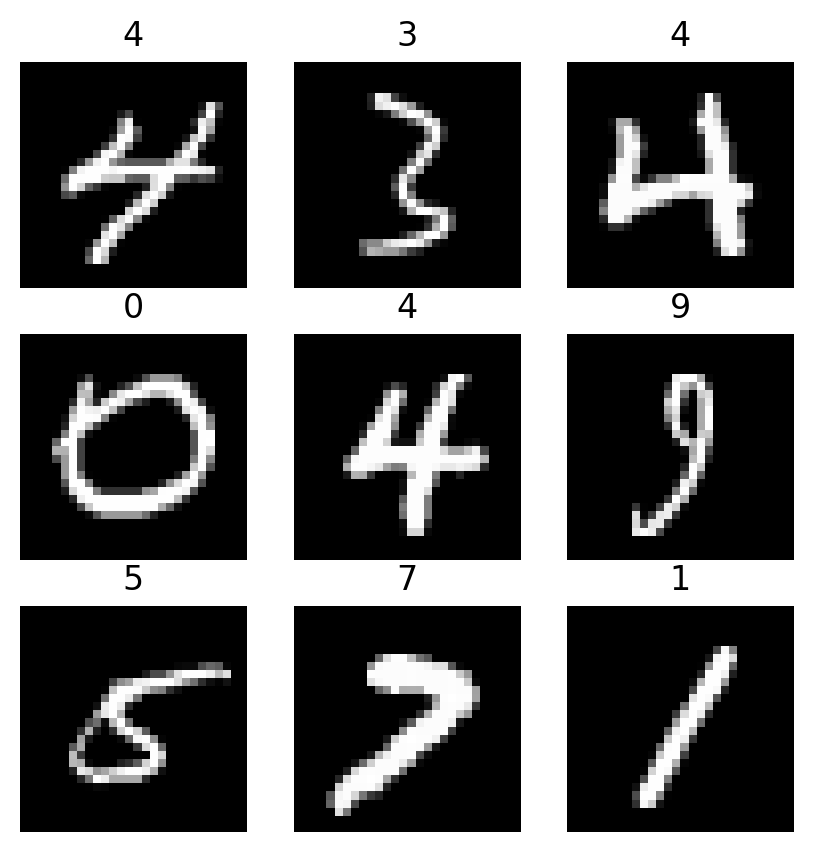

In [5]:
plt.figure(figsize=(5,5))
for idx, i in enumerate(indexes):
    plt.subplot(3,3,idx+1)
    plt.imshow(images[idx], cmap='gray')
    plt.axis('off')
    plt.title(labels[idx])
plt.show()

### Preproessing

In [6]:
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers.merge import concatenate

In [7]:
num_labels = len(np.unique(y_train))

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

x_train = np.reshape(x_train, [-1, x_train.shape[1], x_train.shape[2], 1])
x_train = x_train.astype('float32')/255
x_test = np.reshape(x_test, [-1, x_test.shape[1], x_test.shape[2], 1])
x_test = x_test.astype('float32')/255

input_shape = (x_train.shape[1], x_train.shape[2], 1)
batch_size = 32
kernel_size = 3
pool_size = 2
dropout = 0.4
n_filters = 32

In [8]:
### Left Branch
def left_branch(left_inputs):
    filters = n_filters
    x = left_inputs
    # Conv2D-Dropout-MaxPooling2D 3Layers
    # Update Filters 32-64-128
    for i in range(3):
        conv = Conv2D(filters=filters,
                       kernel_size=kernel_size,
                       padding='same',
                       activation='relu',
                      )(x)
        drop = Dropout(dropout)(conv)
        maxpool = MaxPooling2D(pool_size=pool_size)(drop)
        filters *= 2
        x = maxpool
    return x

In [9]:
### Right Branch
def right_branch(right_inputs):
    filters = n_filters
    y = right_inputs
    # Conv2D-Dropout-MaxPoolig2D 3Layers
    # Update Filters 32-64-128
    for i in range(3):
        conv = Conv2D(filters=filters,
                      kernel_size=kernel_size,
                      padding='same',
                      activation='relu',
                      dilation_rate=2
                     )(y)
        drop = Dropout(dropout)(conv)
        maxpool = MaxPooling2D(pool_size=pool_size)(drop)
        filters *= 2
        y = maxpool
    return y

In [10]:
# Concatenate 2 Branches
left_inputs = keras.Input(shape=input_shape)
right_inputs = keras.Input(shape=input_shape)
concat = concatenate([left_branch(left_inputs), right_branch(right_inputs)])
flat = Flatten()(concat)
drop = Dropout(dropout)(flat)
outputs = Dense(num_labels, activation='softmax')(drop)

Metal device set to: Apple M2


2023-02-02 16:16:22.756754: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-02 16:16:22.756844: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
model = keras.models.Model([left_inputs, right_inputs], outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 28, 28, 32)   320         ['input_2[0][0]']                
                                                                                              

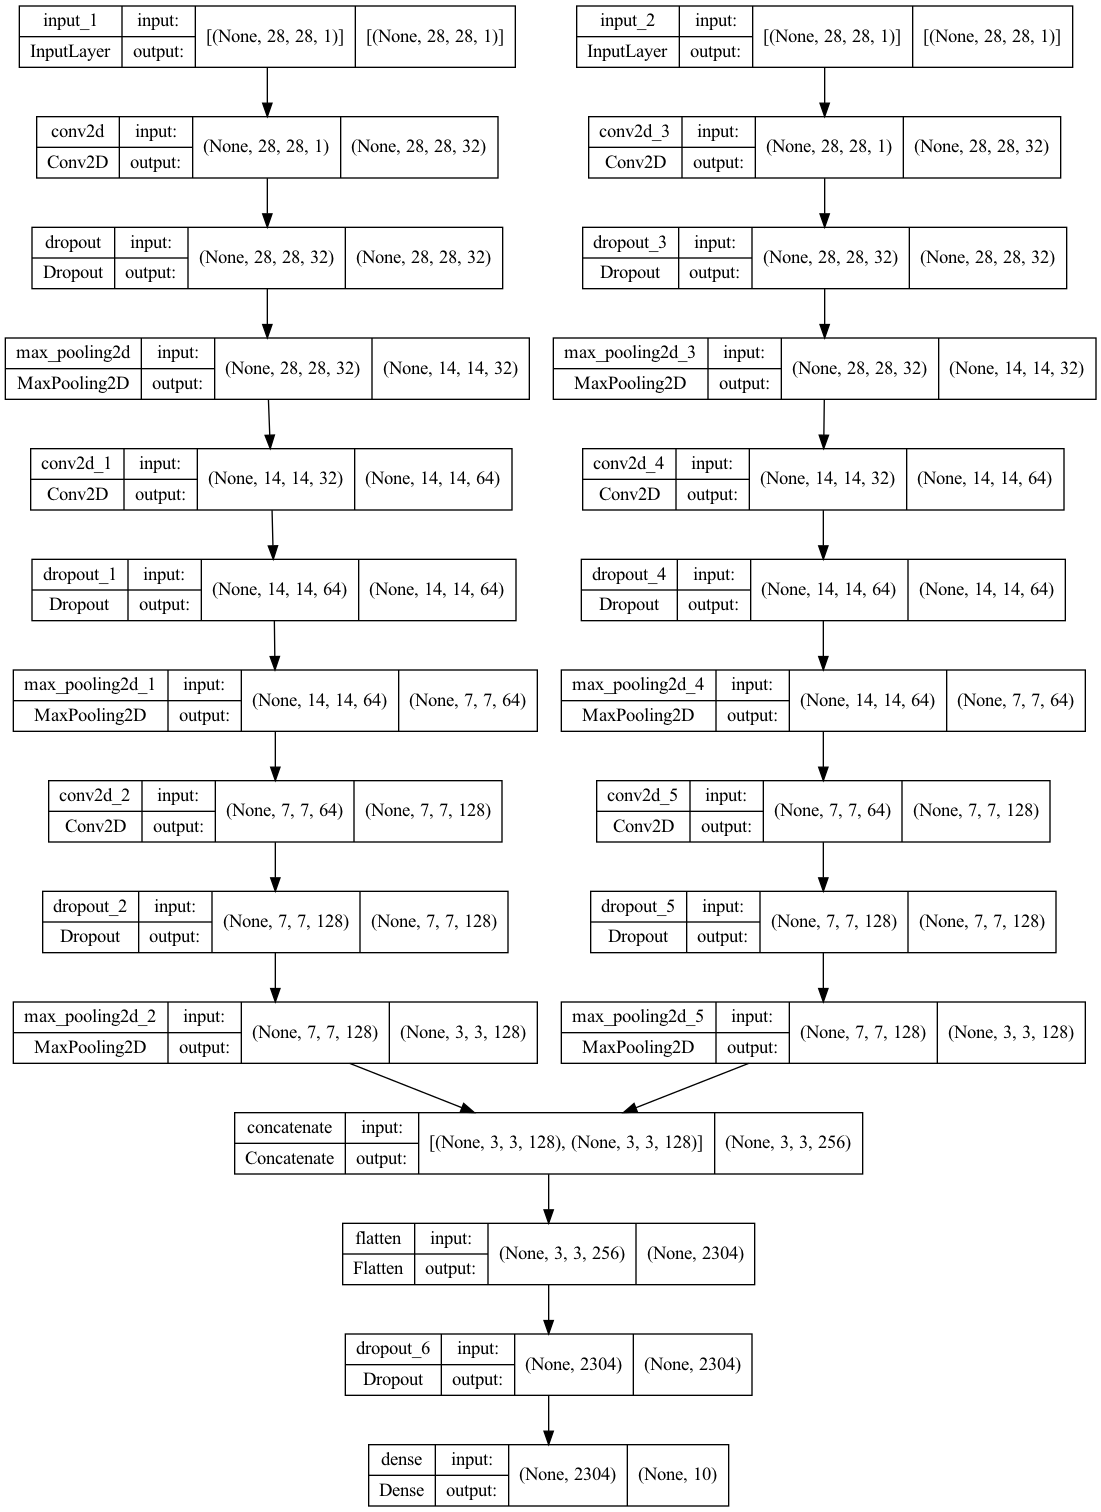

In [12]:
keras.utils.plot_model(model, to_file='cnn-y-network.png', show_shapes=True)

In [13]:
learning_rate = 0.001
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'],
             )

In [14]:
history = model.fit([x_train, x_train], y_train,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=([x_test, x_test], y_test)
                   )

Epoch 1/20


2023-02-02 16:21:09.342768: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-02 16:21:09.766423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 273/1875 [===>..........................] - ETA: 52s - loss: 0.5102 - accuracy: 0.8395

KeyboardInterrupt: 